# Template for analyzing the CLM5-PPE
- Updated Jan 4, 2023
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import seaborn as sns
from pylab import cm

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

In [3]:
import panel as pn
import param
pn.extension()

### imagining the emulated dataset:

In [47]:
def pgroup(p,nx=10):
    g=np.zeros(500)
    for i in range(nx):
        ix=(ds[p]>=i/nx)&(ds[p]<(i+1)/nx)
        g[ix]=i/nx+1/nx/2
    g=xr.DataArray(g,dims='ens')
    g.name=p
    return g

In [42]:
dvs=['TLAI','TWS','GPP','EFLX_LH_TOT']
ds=get_exp('transient',dvs=dvs,yy=(2005,2014)).isel(ens=np.arange(501)>0)
das={v:amean(gmean(ds[v],ds.la)).mean(dim='year').compute() for v in dvs}

In [106]:
das={v:amean(gmean(ds[v],ds.la)).mean(dim='year').compute() for v in dvs}

In [107]:
ds_emulated=xr.Dataset(
            {v:xr.DataArray([das[v].groupby(pgroup(p)).mean().values for p in ds.params.values],
                         coords={'param':ds.params.values,'val':0.05+np.arange(10)/10})
             for v in dvs})


In [108]:
ds_emulated

<xarray.Dataset>
Dimensions:      (param: 32, val: 10)
Coordinates:
  * param        (param) <U19 'FUN_fracfixers' 'KCN' ... 'tpuse_sf' 'wc2wjb0'
  * val          (val) float64 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95
Data variables:
    TLAI         (param, val) float64 0.9952 1.106 1.193 ... 1.256 1.261 1.281
    TWS          (param, val) float64 1.341e+03 1.333e+03 ... 1.323e+03
    GPP          (param, val) float64 1.534e-05 1.687e-05 ... 1.824e-05
    EFLX_LH_TOT  (param, val) float64 20.78 20.99 21.18 ... 21.59 21.79 22.04

### creating the panel plot

In [100]:
def plot1(v,p):

    fig=plt.Figure()
    ax=fig.add_subplot(111)
    ds_emulated[v].sel(param=p).plot.line('-x',ax=ax)
    ax.set_title('')
    ax.set_xlabel(p)
    ax.set_xlim([0,1])
    
    ax.set_ylim([ds_emulated[v].min(),ds_emulated[v].max()])

    return fig

In [104]:
class Parameters(param.Parameterized):
    dataVar   = param.Selector(objects=dvs)
    parameter = param.Selector(objects=list(ds_emulated.param.values))

    def view(self):
        return plot1(self.dataVar,self.parameter)

obj = Parameters()
obj

Parameters(dataVar='TLAI', name='Parameters00107', parameter='FUN_fracfixers')

Row
    [0] ParamMethod(method)
    [1] Column(margin=5, name='Parameters', width=300)
        [0] StaticText(value='<b>Parameters</b>')
        [1] Select(name='DataVar', options=OrderedDict([('TLAI', ...]), value='TWS')
        [2] Select(name='Parameter', options=OrderedDict([('FUN_fracfix...]), value='sucsat_sf')
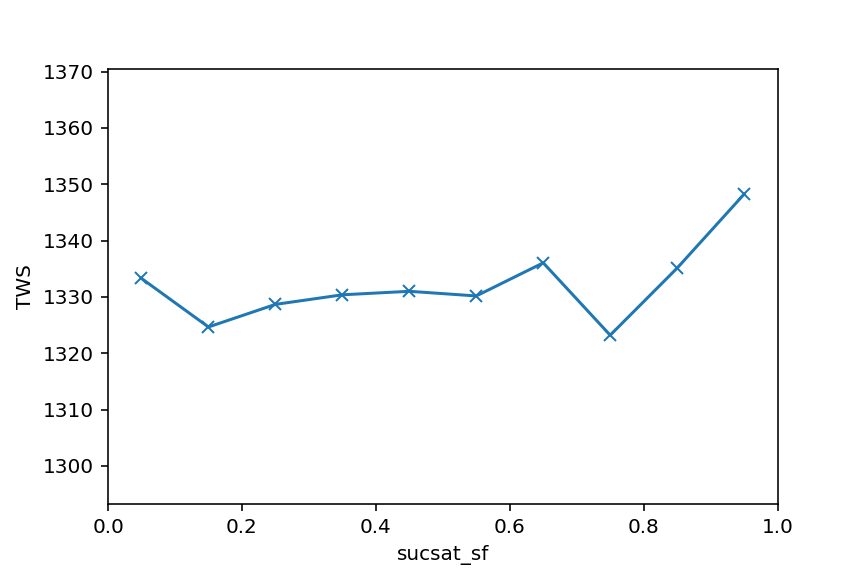

In [109]:
pane=pn.Row(obj.view,obj.param)
pane